In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pathlib import Path
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.models import resnext50_32x4d
from torch.autograd import Variable
import time
import copy
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
path = Path('/kaggle/input/plant-pathology-2020-fgvc7/')
train_data = pd.read_csv(path / 'train.csv')
train_data.loc[train_data['multiple_diseases'] == 1, 'rust':] = 1
print(train_data)

        image_id  healthy  multiple_diseases  rust  scab
0        Train_0        0                  0     0     1
1        Train_1        0                  1     1     1
2        Train_2        1                  0     0     0
3        Train_3        0                  0     1     0
4        Train_4        1                  0     0     0
...          ...      ...                ...   ...   ...
1816  Train_1816        0                  0     0     1
1817  Train_1817        1                  0     0     0
1818  Train_1818        1                  0     0     0
1819  Train_1819        0                  0     1     0
1820  Train_1820        0                  0     0     1

[1821 rows x 5 columns]


# Creating a custom data set class for loading images and classes
Inherits from the PyTorch Dataset class. The data set is then instantiated using the specified transforms (crops, normalizes, and converts to tensor). A test-train split is then created for model validation.

In [3]:
class PlantPathology(Dataset):

    def __init__(self, _data_frame, root_dir, transform=None):
        self.root_dir = root_dir
        self.data_frame = _data_frame
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = list(idx)
        img_name = self.root_dir / (self.data_frame.iloc[idx]['image_id'] + '.jpg')
        image = io.imread(img_name)
        labels = np.array([
                  self.data_frame.iloc[idx]['healthy'], 
                  self.data_frame.iloc[idx]['multiple_diseases'],
                  self.data_frame.iloc[idx]['rust'],
                  self.data_frame.iloc[idx]['scab']
                  ])
        sample = {'image': image, 'labels': labels}
        if self.transform:
            sample['image'] = self.transform(sample['image'])
        return sample

In [4]:
transform_train = transforms.Compose([transforms.ToPILImage(),
                                transforms.RandomResizedCrop((224, 224), 
                                                             scale=(0.7, 1.0)),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize(
                                    [0.485, 0.456, 0.406], 
                                    [0.229, 0.224, 0.225])])
transform_test = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize(
                                    [0.485, 0.456, 0.406], 
                                    [0.229, 0.224, 0.225])])
data = pd.read_csv(path / 'train.csv')
shuffled = np.arange(0, data.shape[0])
np.random.shuffle(shuffled)
train_data = data.iloc[shuffled[0: int(0.9 * shuffled.shape[0])]]
test_data = data.iloc[shuffled[int(0.9 * shuffled.shape[0]):]]
# train_data.to_csv(path / 'train_split.csv')
# test_data.to_csv(path / 'test_split.csv')
# train_data = None
# test_data = None
train_dataset = PlantPathology(train_data, path / 'images',
                               transform=transform_train)
test_dataset = PlantPathology(test_data, path / 'images',
                               transform=transform_test)

# Validating Dataset
Creating and testing a function for visualizing an image from the custom dataset and its labels.

In [5]:
def imshow(inp):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp) 

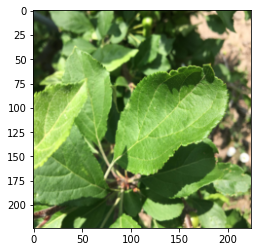

[1 0 0 0]
torch.Size([3, 224, 224])


In [6]:
fig = plt.figure()
item = train_dataset[122]
imshow(item['image'])
plt.show()
print(item['labels'])
print(item['image'].shape)

In [7]:
datasets = {'train': train_dataset,
            'val': test_dataset}
# if OOM on GPU, try reducing batch_size and num_workers in the 'dataloaders'
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=16,
                                             shuffle=True, num_workers=8)
              for x in ['train', 'val']}
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}

# Model
importing the resnet model and replacing its final linear layer to have only 4 outputs. I have found that performance is better when pretrained weights are updated with backpropagation, so I commented out the requires_grad = False statement.

In [8]:
model = resnext50_32x4d(pretrained=True)
# for param in model.parameters():
#     param.requires_grad = False
model.fc = torch.nn.Linear(2048, 4)
# print(model)
if torch.cuda.is_available():
    model.cuda()

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/checkpoints/resnext50_32x4d-7cdf4587.pth


# Training
The following function provides a generalized method of training a model, and will work on either CPU or GPU.

In [9]:
def train_model(model, _criterion, _optimizer, _scheduler, num_epochs=20):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                inputs = data['image']
                labels = data['labels']
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, torch.max(labels, 1)[1])
                    # loss = criterion(outputs, inputs)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == torch.max(labels, 1)[1])
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [10]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [11]:
model_ft = train_model(model, criterion, optimizer, scheduler, num_epochs=30)

Epoch 0/29
----------
train Loss: 0.8314 Acc: 0.7332
val Loss: 0.6898 Acc: 0.6831

Epoch 1/29
----------
train Loss: 0.4637 Acc: 0.8773
val Loss: 0.3510 Acc: 0.9180

Epoch 2/29
----------
train Loss: 0.4281 Acc: 0.8901
val Loss: 0.6121 Acc: 0.8087

Epoch 3/29
----------
train Loss: 0.3454 Acc: 0.9017
val Loss: 0.3796 Acc: 0.9126

Epoch 4/29
----------
train Loss: 0.3354 Acc: 0.8962
val Loss: 0.2468 Acc: 0.9290

Epoch 5/29
----------
train Loss: 0.1886 Acc: 0.9432
val Loss: 0.1766 Acc: 0.9290

Epoch 6/29
----------
train Loss: 0.1381 Acc: 0.9585
val Loss: 0.1826 Acc: 0.9399

Epoch 7/29
----------
train Loss: 0.1863 Acc: 0.9457
val Loss: 0.1783 Acc: 0.9399

Epoch 8/29
----------
train Loss: 0.1850 Acc: 0.9469
val Loss: 0.2065 Acc: 0.9344

Epoch 9/29
----------
train Loss: 0.1428 Acc: 0.9548
val Loss: 0.1688 Acc: 0.9454

Epoch 10/29
----------
train Loss: 0.1544 Acc: 0.9567
val Loss: 0.1646 Acc: 0.9399

Epoch 11/29
----------
train Loss: 0.1476 Acc: 0.9573
val Loss: 0.1669 Acc: 0.9399

Ep

# Prediction
Now that the optimal model has been found, the following code predicts labels for the test data and submission.

In [12]:
submission_data = pd.read_csv(path / 'test.csv')
submission_data['healthy'] = np.zeros(submission_data.shape[0])
submission_data['multiple_diseases'] = np.zeros(submission_data.shape[0])
submission_data['rust'] = np.zeros(submission_data.shape[0])
submission_data['scab'] = np.zeros(submission_data.shape[0])
submission_dataset = PlantPathology(submission_data, path / 'images',
                               transform=transform_test)
submission_dataloader = torch.utils.data.DataLoader(submission_dataset, batch_size=4,
                                             shuffle=False, num_workers=4)

In [13]:
model_ft.eval()
results = []
torch.set_grad_enabled(False)
for data in submission_dataloader:
    input = data['image']
    input = input.to(device)
    outputs = model_ft(input)
    _, r = outputs.max(1)
    # print(r)
    results.append(np.squeeze(r.cpu().numpy()))
    # print(results)
# print(results)

In [14]:
results_array = np.hstack(tuple(results))
labels = submission_data.columns[1:]
for i in range(0, results_array.shape[0]):
    submission_data.loc[i, labels[results_array[i]]] = 1
print(submission_data)
submission_data.to_csv('/kaggle/working/submission.csv', index=False)

       image_id  healthy  multiple_diseases  rust  scab
0        Test_0      0.0                0.0   1.0   0.0
1        Test_1      0.0                0.0   1.0   0.0
2        Test_2      0.0                0.0   0.0   1.0
3        Test_3      1.0                0.0   0.0   0.0
4        Test_4      0.0                0.0   1.0   0.0
...         ...      ...                ...   ...   ...
1816  Test_1816      0.0                0.0   1.0   0.0
1817  Test_1817      0.0                0.0   0.0   1.0
1818  Test_1818      0.0                0.0   1.0   0.0
1819  Test_1819      1.0                0.0   0.0   0.0
1820  Test_1820      0.0                0.0   0.0   1.0

[1821 rows x 5 columns]
